## 1. Load procresses and module

First add processes via `addprocs`, on my computer with 8 threads I'll add 7 (I wrap in an if block so that I don't accidentally do this over and over again).

In [1]:
if nprocs() == 1; addprocs(7); end;

Next, run the `@startup` macro (defined in my ~/.julia/config/startup.jl file).
The relevant effect is that it loads the `Plots` package and loads the file path to ScalarFDFD on all processes.
It also sets the color theme to its argument, or to `default` if none is provided.

In [2]:
@startup :sand

Load the ScalarFDFD module on all processes:

In [3]:
@everywhere using ScalarFDFD

‚îå Info: Recompiling stale cache file /Users/wrs/.julia/compiled/v1.0/ScalarFDFD.ji for ScalarFDFD [top-level]
‚îî @ Base loading.jl:1187
ERROR: LoadError: LoadError: syntax: unexpected ","
Stacktrace:
 [1] include at ./boot.jl:317 [inlined]
 [2] include_relative(::Module, ::String) at ./loading.jl:1041
 [3] include at ./sysimg.jl:29 [inlined]
 [4] include(::String) at /Users/wrs/wrs julia/ScalarFDFD/src/ScalarFDFD.jl:1
 [5] top-level scope at none:0
 [6] include at ./boot.jl:317 [inlined]
 [7] include_relative(::Module, ::String) at ./loading.jl:1041
 [8] include(::Module, ::String) at ./sysimg.jl:29
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:319 [inlined]
 [11] eval(::Expr) at ./client.jl:389
 [12] top-level scope at ./none:3
in expression starting at /Users/wrs/wrs julia/ScalarFDFD/src/band_structure.jl:126
in expression starting at /Users/wrs/wrs julia/ScalarFDFD/src/ScalarFDFD.jl:116


      From worker 5:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 4:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 7:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 8:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 3:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 6:	ERROR: LoadError: LoadError: syntax: unexpected ","
      From worker 5:	Stacktrace:
      From worker 4:	Stacktrace:
      From worker 7:	Stacktrace:
      From worker 8:	Stacktrace:
      From worker 3:	Stacktrace:
      From worker 6:	Stacktrace:
      From worker 5:	 [1] include at ./boot.jl:317 [inlined]
      From worker 4:	 [1] include at ./boot.jl:317 [inlined]
      From worker 7:	 [1] include at ./boot.jl:317 [inlined]
      From worker 8:	 [1] include at ./boot.jl:317 [inlined]
      From worker 3:	 [1] include at ./boot.jl:317 [inlined]
      From worker 6:	 [1] include at ./boot.jl:317 [inlined

CompositeException: On worker 2:
Failed to precompile ScalarFDFD [top-level] to /Users/wrs/.julia/compiled/v1.0/ScalarFDFD.ji.
error at ./error.jl:33
macro expansion at ./logging.jl:313 [inlined]
compilecache at ./loading.jl:1187
macro expansion at ./logging.jl:311 [inlined]
_require at ./loading.jl:944
require at ./loading.jl:855
macro expansion at ./logging.jl:311 [inlined]
require at ./loading.jl:837
eval at ./boot.jl:319
#116 at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:276
run_work_thunk at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:56
run_work_thunk at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:65
#102 at ./task.jl:259
#remotecall_wait#154(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::Distributed.Worker, ::Module, ::Vararg{Any,N} where N) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:421
remotecall_wait(::Function, ::Distributed.Worker, ::Module, ::Vararg{Any,N} where N) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:412
#remotecall_wait#157(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::Int64, ::Module, ::Vararg{Any,N} where N) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:433
remotecall_wait(::Function, ::Int64, ::Module, ::Vararg{Any,N} where N) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:433
(::getfield(Distributed, Symbol("##163#165")){Module,Expr})() at ./task.jl:259

...and 7 more exception(s).


## 2. Building a Simulation

Build the computation in stages. The computational region is $\Omega$, so the boundary is $\partial\Omega$. We specify the boundary conditions with `bc`, the boundary layers with `bl`, and the boundary layer thickness with `bl_depth`.

Finally we construct the boundary object with a call to `Boundary`

In [4]:
‚àÇŒ© = [-8  -8
       9  9]

bc = :d         # boundary condition (in this case Dirichlet)
bl = :pml       # boundary layer (in this case PML)
bl_depth = 3    # boundary layer depth

bnd = Boundary(‚àÇŒ©=‚àÇŒ©, bc=bc, bl=bl, bl_depth=bl_depth)    # boundary object

UndefVarError: UndefVarError: Boundary not defined

Now build the computational lattice, with lattice spacing `dx` 

In [5]:
dx = .05
dis = Discretization(dx)

UndefVarError: UndefVarError: Discretization not defined

Now the fun part, building the interior of the computational domain.
Here our goal is to build crossed photonic crystal waveguides.

First defince a photonic crystal lattice `lat` with a call to `Bravais`:

In [6]:
lat = Bravais(a=1, b=1)

UndefVarError: UndefVarError: Bravais not defined

This defines a square lattice. Let's initialize a domain object with a call to `build_pc_domain`

In [7]:
pc = build_pc_domain(lat)

UndefVarError: UndefVarError: build_pc_domain not defined

There's a lot of information in that printout, but at the moment most of it isn't helpful.

Now we get to add structure to the unit cell. We will add two pillars, each with index $n=3$.

One will have radius $R=.1$, located $(.3,.3)$ from the lower left-hand portion of the unit cell, while the other will have $R=.2$ at $(.7,.7)$.

In [8]:
pc = add_circle_to_pc(pc, :sw; R=.1, n‚ÇÅ = 3, x0=.3, y0=.3)
pc = add_circle_to_pc(pc, :sw; R=.20, n‚ÇÅ = 3, x0=.7, y0=.7)

UndefVarError: UndefVarError: add_circle_to_pc not defined

Compare this printout to that from the initialization of `pc` to see that we've added some structure to the interior. To package this all up we make a call to `System`:

In [9]:
sys = System(pc)

UndefVarError: UndefVarError: System not defined

Right now we've constructed a superlattice (a $1\times1$ unit cell tiled over a $17\times17$ domain).

Next we want to add waveguides: the first will be vertical, and the second horizontal.

In [10]:
sys = add_pc_waveguide(sys; width=1, direction=:horizontal)
sys = add_pc_waveguide(sys; width=1, direction=:vertical)

UndefVarError: UndefVarError: add_pc_waveguide not defined

Notice that each asymptotic region defines its own waveguide, though the asymptotic regions can be joined by a bulk waveguide in the simulated domain, as is the case with, say, waveguides 1 & 2.

Since we are going to do a scattering calculation in this example, we need to define what our channels are. This is done by calls to `Channels`, with the first argument a reference to which waveguide the channel lives in, and the second argument is which quantum number to associate with that channel (in this case, the quantum number is the transverse mode number).

Here we will define channels to be coming from the bottom and coming from the left, both in the fundamental mode.

In [11]:
chn1 = Channels(1,1)
chn2 = Channels(3,1)
sct = Scattering(chn1,chn2)

UndefVarError: UndefVarError: Channels not defined

Finally we are ready to put the whole simulation together into a neat package!

In [12]:
sim1 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct, disp_opt=true)

UndefVarError: UndefVarError: sys not defined

To visualize what we just made, simply

In [13]:
p = plot(sim1)

UndefVarError: UndefVarError: sim1 not defined

and save the result via

In [14]:
savefig(p, "test1/pc_sim1.pdf")

UndefVarError: UndefVarError: p not defined

### 3. Band Structure

Let's see what frequencies we should be operating at by looking at the band structure is.

Note we specify parallel to be true, but in face it defaults to checking whether multiple processes are active and responding accordingly.

Here we are setting the `zone` to 1, which means the lower quarter of the full Brillouin Zone. We could have specified an arry of zones, or one of `:reduced`, `:half`, or `:full`.

`:reduced` does what it says it does, though it doesn't reduce the lattice if you specify primitives that are indeed not primitive.
`:full` takes a bunch of paths across each zone, and `:half` just does it for zones 1 and 2.

Note that in a Hermitian cell, zones 1 and 4, and separately zones 2 and 3 are equivalent (up to a reflection), so generally `:full` is redundant. If there is further symmetry within the cell, then zone 1 or `:reduced` will be sufficient.

In [15]:
bands1, gaps1 = band_structure(sim1; waveguide=1, zone=1, parallel=true);

UndefVarError: UndefVarError: band_structure not defined

Plot and save the result.

All relevant plots are easiest if the first argument is the simulation.

The order and number of the rest don't really matter.

In [16]:
p = plot(sim1, gaps1, bands1, lw=2)
savefig(p, "test1/pc_band_structure1.pdf")
p

UndefVarError: UndefVarError: sim1 not defined

### 4. Dispersion

Build the dispersion curves for each waveguide. This is not necessary to do explicitly, as the first time it is needed for a scattering calculation it checks to see if it has already been done, and, if not, it does it and save the result to `sim`. But doing it this way allows much more control, though we are not using that here.

In [17]:
build_dispersions!(sim1)

UndefVarError: UndefVarError: build_dispersions! not defined

To take a look at the dispersion curve, we just

In [18]:
p = plot(sim1, sim1.sct, gap_color=:darkred); savefig(p, "test1/pc_wg_dispersion1.pdf");
p

UndefVarError: UndefVarError: sim1 not defined

though `plot(sim,sim)` would have done just the same.

### 5. Scattering

All this tells us that we can meaningfully expect to do a scattering calculation, are œâ=2.2 (say)

In [19]:
œà1_sct, œà1_tot = scattering(sim1, 2.2, [1,1]);

UndefVarError: UndefVarError: scattering not defined

the third argument is an array of amplitudes (one for each channel)

let's look at the result!

In [20]:
p = plot(sim1, œà1_tot);
savefig(p, "test1/pc_scattering1.pdf");
p

UndefVarError: UndefVarError: sim1 not defined

and make a cool animation

In [21]:
animate(wave(sim1, œà1_tot, by=real), size=(500,500), "test1/pc_scattering1.gif")

UndefVarError: UndefVarError: wave not defined

which sadly won't show in Jupyterlab, but does in Jupyter Notebooks.

Note that plot attributes can be fed as optional keyword arguments to `animate`.

The only additional arguments fed to `wave` are the theme (in this case `:default`, it currently defaults (bad name) to `:orange`, but this can be changed with change to the appropriate global variable specified in the defaults.jl file) and `by`, which is the function used to plot $\psi$, and `truncate`, which defaults to `true`, and determines whether to include the boundary layer in the plot.

# B. Second example

let's do another example, this time with a lot fewer comments.

We'll look at a terminated waveguide in a hexagonal photonic crystal.

In [22]:
‚àÇŒ© = [-7  -8*sqrt(3)/2
       14  8*sqrt(3)/2];

Note that for the time being, we must manually enforce that the overall domain is commensurate with the unit cells (in particular for this example the height must be an integer multiple of $\sqrt{3a/4}$)

In [23]:
bc = :d
bl = [:pml :none
    :none :none]
   
bl_depth = 4
bnd = Boundary(‚àÇŒ©=‚àÇŒ©, bc=bc, bl=bl, bl_depth=bl_depth)

dx = .01
dis = Discretization(dx);

UndefVarError: UndefVarError: Boundary not defined

this time we use the slightly more appropriate absorbing boundary layer for photonic crystals, but it must be longer (I think?)

This time we specify the angle of the second primitive vector. This choice corresponds to a hexagonal lattice

In [5]:
pc = build_pc_domain(Bravais(a=1, b=1, Œ≤=œÄ/3), Regions(), n‚ÇÅ = sqrt(13));

add a pillar to the middle of the cell

In [6]:
pc = add_circle_to_pc(pc, :corners; R=.48, n‚ÇÅ = sqrt(1));
sys = System(pc);

In [7]:
sim = Simulation(pc; dis=dis, Na=1, Nb=1)
# plot(sim)
# sim.lat.v2

Simulation: 

sys: 	domain 1 type: pc


bnd: 		-------------------------
	bound.	|	   :p    	|
	cond-	|   :p    	   :p   |
	 ition	|	   :p    	|
		-------------------------
		|	+0.866		|
	‚àÇŒ©	| +0.000	+1.000	|
		|	+0.000		|
		-------------------------
		|	+0.866		|
	‚àÇŒ©_tr	| +0.000	+1.000	|
		|	+0.000		|
		-------------------------
	bound.	|	:none   	|
	layer	|:none   	:none   |
		|	:none   	|
		-------------------------
	bound.	|	+0.000		|
	layer	| +0.000	+0.000	|
	depth	|	+0.000		|
		-------------------------


dis: 	N: [100, 87]
	sub-pixel number: 20
	dx: [0.01, 0.00995431]

sct: 

tls: 	D‚ÇÄ: 0.0
	œâ‚ÇÄ: 10.0
	Œ≥‚üÇ: 1.0e8

lat: Bravais: 
	primitive vector 1: 1.00, ‚à†0.00¬∞
	primitive vector 2: 1.00, ‚à†60.00¬∞
	origin: (0.00, 0.00)

In [27]:
bands, gaps = band_structure(sim, ([0, 1/2, 2/3, 0],[0, 0, 1/3, 0]), 21);
# plot(sim, bands, gaps, ks)

band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:01


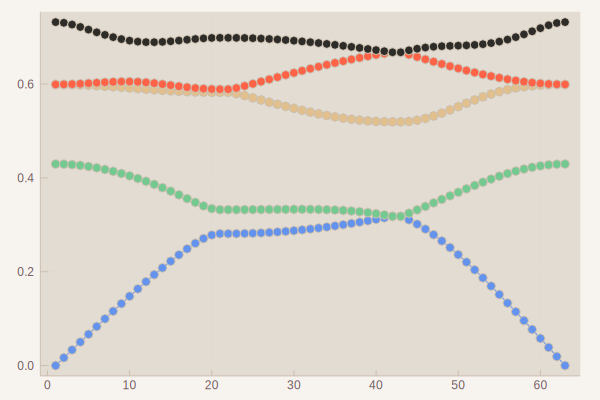

In [28]:
plot(bands'/2œÄ; legend=false, marker=:o)
# bands'/2œÄ

In [30]:
; mpb  ~/Desktop/band_triangular_holes.ctl >  ~/Desktop/band_triangular_holes.out

init-params: initializing eigensolver data
Computing 1 bands with 1.000000e-07 tolerance.
Working in 2 dimensions.
Grid size is 100 x 100 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.48, height 1e+20, axis (0, 0, 1)
          epsilon = 1, mu = 1
Geometric object tree has depth 3 and 16 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
31 k-points:
     (0,0,0)
     (0.05,0,0)
     (0.1,0,0)
     (0.15,0,0)
     (0.2,0,0)
     (0.25,0,0)
     (0.3,0,0)
     (0.35,0,0)
     (0.4,0,0)
     (0.45,0,0)
     (0.5,0,0)
     (0.5,0.05,0)
     (0.5,0.1,0)
     (0.5,0.15,0)
     (0.5,0.2,0)
     (0.5,0.25,0)
     (0.5,0.3,0)
     (0.5,0.35,0)
     (0.5,0.4,0)
     (0.5

Backtrace:
           3 (apply-smob/1 #<catch-closure 10709f660>)
In ice-9/eval.scm:
    619:8  2 (_ #(#(#<directory (guile-user) 1073520a0>) ">"))
    619:8  1 (_ #(#(#(#<directory (guile-user) 1073520a0>) ">") "" ("" . #)))
In unknown file:
           0 (primitive-load ">")

ERROR: In procedure primitive-load:
In procedure open-file: No such file or directory: ">"


In [33]:
; sh ~/Desktop/extract_tmfreqs.sh ~/Desktop/band_triangular_holes.out >  ~/Desktop/band_triangular_holes.dat

 0, 0, 0
 0.05, 0, 0.0334683
 0.1, 0, 0.0667512
 0.15, 0, 0.0996546
 0.2, 0, 0.131965
 0.25, 0, 0.163435
 0.3, 0, 0.193757
 0.35, 0, 0.222493
 0.4, 0, 0.248867
 0.45, 0, 0.270832
 0.5, 0, 0.281154
 0.5, 0.05, 0.279234
 0.5, 0.1, 0.274839
 0.5, 0.15, 0.270246
 0.5, 0.2, 0.266983
 0.5, 0.25, 0.265818
 0.5, 0.3, 0.266984
 0.5, 0.35, 0.270249
 0.5, 0.4, 0.274843
 0.5, 0.45, 0.279241
 0.5, 0.5, 0.281162
 0.45, 0.45, 0.270837
 0.4, 0.4, 0.248869
 0.35, 0.35, 0.222494
 0.3, 0.3, 0.193757
 0.25, 0.25, 0.163436
 0.2, 0.2, 0.131965
 0.15, 0.15, 0.0996546
 0.1, 0.1, 0.0667512
 0.05, 0.05, 0.0334683
 0, 0, 0


In [ ]:
b1 = bands[1][1][1][1,:]/2œÄ;
b2 = bands[1][1][2][1,:]/2œÄ;
b3 = bands[1][1][3][1,:]/2œÄ;
[b1 b2 b3]

[0.186922 0.390894]


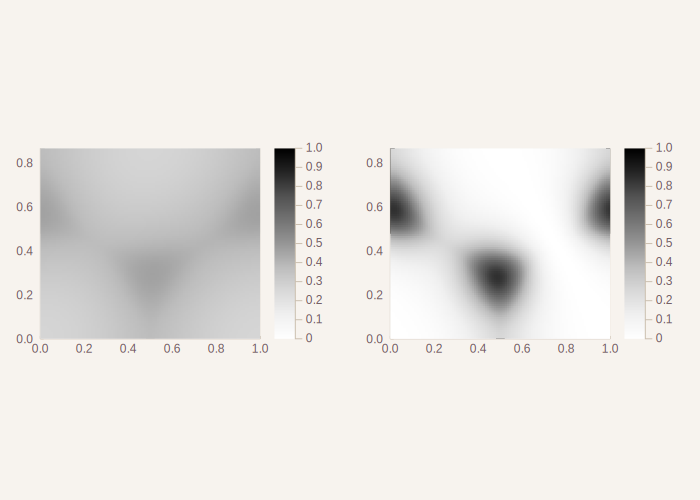

In [108]:
k, œà = eig_k(sim, 2œÄ*.001, 2; ka=-2œÄ*.1666/1, kb=2œÄ*.1666/1)
println(real(k)'/2œÄ)
plot(sim, œà, by=abs2, size=(700,500), seriesalpha=1, colorbar=true)

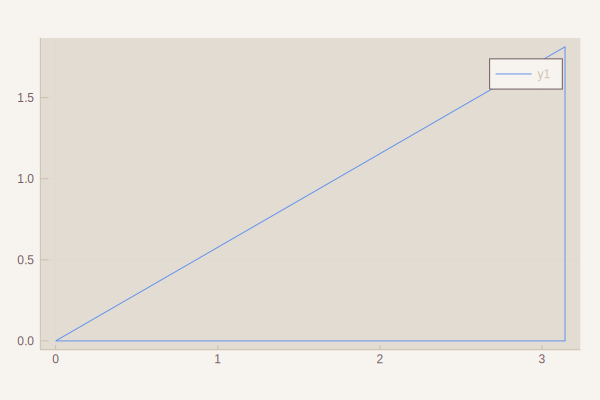

In [91]:
k_bloch = ([0, 1/2, 1/3, 0],[0, 0, 1/3, 0])
num_bloch_interpolations=15
reciprocal_basis = true

kas = Array{Float64}(undef, num_bloch_interpolations*(length(k_bloch[1])-1))
    kbs = deepcopy(kas)
    for i ‚àà 1:length(k_bloch[1])-1
        if reciprocal_basis
            ka_start = k_bloch[1][i]*2œÄ*sim.lat.v1[1]/sim.lat.a + k_bloch[2][i]*2œÄ*sim.lat.v2[1]/sim.lat.b
            kb_start = k_bloch[1][i]*2œÄ*sim.lat.v1[2]/sim.lat.a + k_bloch[2][i]*2œÄ*sim.lat.v2[2]/sim.lat.b

            ka_stop = k_bloch[1][i+1]*2œÄ*sim.lat.v1[1]/sim.lat.a + k_bloch[2][i+1]*2œÄ*sim.lat.v2[1]/sim.lat.b
            kb_stop = k_bloch[1][i+1]*2œÄ*sim.lat.v1[2]/sim.lat.a + k_bloch[2][i+1]*2œÄ*sim.lat.v2[2]/sim.lat.b
        else
            ka_start = k_bloch[1][i]
            kb_start = k_bloch[2][i]

            ka_stop = k_bloch[1][i+1]
            kb_stop = k_bloch[2][i+1]
        end
        ka_temp = LinRange(ka_start, ka_stop, num_bloch_interpolations)
        kb_temp = LinRange(kb_start, kb_stop, num_bloch_interpolations)
        for j ‚àà 1:num_bloch_interpolations
            kas[(i-1)*num_bloch_interpolations + j] = ka_temp[j]
            kbs[(i-1)*num_bloch_interpolations + j] = kb_temp[j]
        end
    end
plot(kas,kbs, aspectratio=1)

In [115]:
using SparseArrays

‚àá‚ÇÅ¬≤, ‚àá‚ÇÇ¬≤ = ScalarFDFD.laplacians_sans_bc(sim, 2.)
ScalarFDFD.laplacians_with_bc!(‚àá‚ÇÅ¬≤, ‚àá‚ÇÇ¬≤, sim)

sim.bnd.weights[4]

II, J, V, Na, Nb = ScalarFDFD.periodic_boundary_weights(sim, 1)
Nb
            

276-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ‚ãÆ  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [26]:
using LinearAlgebra, SparseArrays
C1 = sim.bnd.weights[1]

ka=0; kb=0

    C1·µÄ = sim.bnd.weights[2]
    N1a = sim.bnd.weights[3]
    N1b = sim.bnd.weights[4]
    N1a·µÄ = sim.bnd.weights[5]
    N1b·µÄ = sim.bnd.weights[6]
    C2 = sim.bnd.weights[7]
    C2·µÄ = sim.bnd.weights[8]
    N2a = sim.bnd.weights[9]
    N2b = sim.bnd.weights[10]
    N2a·µÄ = sim.bnd.weights[11]
    N2b·µÄ = sim.bnd.weights[12]

    ùïÄ1 = sparse(complex(1.,0)I, sim.dis.N[1], sim.dis.N[1])
    ùïÄ2 = sparse(complex(1.,0)I, sim.dis.N[2], sim.dis.N[2])

    œï1 = ka*sim.lat.a*N1a + kb*sim.lat.b*N1b
    œï1·µÄ = ka*sim.lat.a*N1a·µÄ + kb*sim.lat.b*N1b·µÄ
    œï2 = ka*sim.lat.a*N2a + kb*sim.lat.b*N2b
    œï2·µÄ = ka*sim.lat.a*N2a·µÄ + kb*sim.lat.b*N2b·µÄ

    C1 = C1.*exp.(+1im*œï1) + C1·µÄ.*exp.(-1im*œï1·µÄ)
    C2 = C2.*exp.(+1im*œï2) + C2·µÄ.*exp.(-1im*œï2·µÄ)

N2b

5520√ó5520 SparseMatrixCSC{Float64,Int64} with 320 stored entries:
  [40  ,    1]  =  0.0
  [41  ,    1]  =  -1.0
  [41  ,    2]  =  -1.0
  [42  ,    2]  =  -1.0
  [42  ,    3]  =  -1.0
  [43  ,    3]  =  -1.0
  [43  ,    4]  =  -1.0
  [44  ,    4]  =  -1.0
  [44  ,    5]  =  -1.0
  [45  ,    5]  =  -1.0
  [45  ,    6]  =  -1.0
  [46  ,    6]  =  -1.0
  ‚ãÆ
  [34  , 5515]  =  0.0
  [35  , 5515]  =  0.0
  [35  , 5516]  =  0.0
  [36  , 5516]  =  0.0
  [36  , 5517]  =  0.0
  [37  , 5517]  =  0.0
  [37  , 5518]  =  0.0
  [38  , 5518]  =  0.0
  [38  , 5519]  =  0.0
  [39  , 5519]  =  0.0
  [39  , 5520]  =  0.0
  [40  , 5520]  =  0.0

In [83]:
i1, j1, k1 = findnz(C‚Çê)
    i2, j2, k2 = findnz(C‚Çê·µÄ)
    C1 = sparse(i1,j1, k1.*exp.(+1im*œï1), prod(sim.dis.N), prod(sim.dis.N)) +
         sparse(i2,j2, k2.*exp.(-1im*œï1), prod(sim.dis.N), prod(sim.dis.N))

    i1, j1, k1 = findnz(C·µ¶)
    i2, j2, k2 = findnz(C·µ¶·µÄ)
    C2 = sparse(i1,j1, k1.*exp.(+1im*œï2), prod(sim.dis.N), prod(sim.dis.N)) +
         sparse(i2,j2, k2.*exp.(-1im*œï2), prod(sim.dis.N), prod(sim.dis.N))

N1a

90√ó90 SparseMatrixCSC{Float64,Int64} with 36 stored entries:
  [1 ,  1]  =  1.0
  [81,  9]  =  1.0
  [1 , 10]  =  1.0
  [81, 10]  =  1.0
  [1 , 11]  =  1.0
  [11, 11]  =  1.0
  [1 , 20]  =  1.0
  [11, 20]  =  1.0
  [11, 21]  =  1.0
  [21, 21]  =  1.0
  [11, 30]  =  1.0
  [21, 30]  =  1.0
  ‚ãÆ
  [61, 59]  =  1.0
  [41, 60]  =  1.0
  [51, 60]  =  1.0
  [61, 60]  =  1.0
  [61, 69]  =  1.0
  [71, 69]  =  1.0
  [61, 70]  =  1.0
  [71, 70]  =  1.0
  [71, 79]  =  1.0
  [71, 80]  =  1.0
  [81, 89]  =  1.0
  [81, 90]  =  1.0

Add a waveguide, this time it will terminate in the bulk

In [141]:
sys = add_pc_waveguide(sys; width=1, direction=:west)

System with 4 domains: 
	domain 1 type: pc_waveguide, left, waveguide 1
	domain 2 type: pc_waveguide_background, left, waveguide 1
	domain 3 type: bulk_pc_waveguide_x
	domain 4 type: pc

	waveguide 1 domains: [1, 2]



Now we add one channel for scattering, and build the simulation

sub-pixel smoothing 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:03
sub-pixel smoothing 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:03


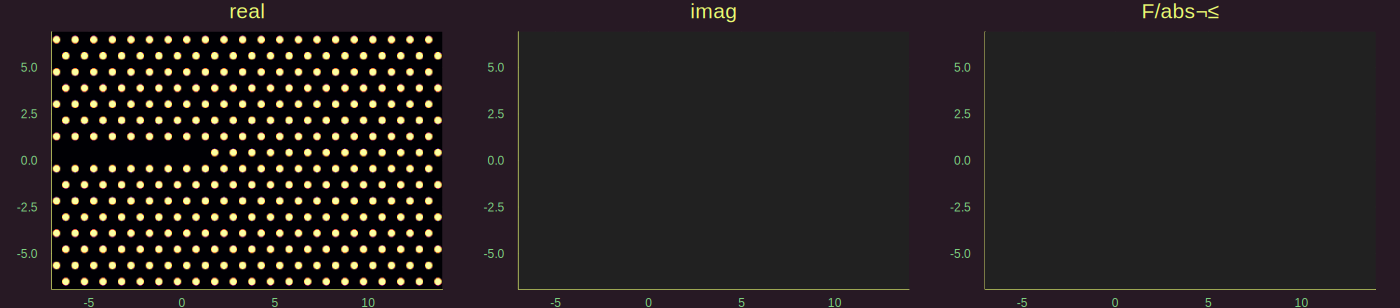

In [21]:
sct = Scattering([Channels(1,1)])

sim2 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct, disp_opt=true)

p = plot(sim2); savefig(p,"test2/pc_sim2.pdf");
p

### Band Structure

This time let's map out the whole surface, but over the reduced zone (sort of) (by making num_bloch an array instead of a number)

In [22]:
bands2, gaps2 = band_structure(sim2; waveguide=1, num_bloch=[21], zone=:reduced);

waveguide band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:02


same plotting command as before now plots the whole surface!

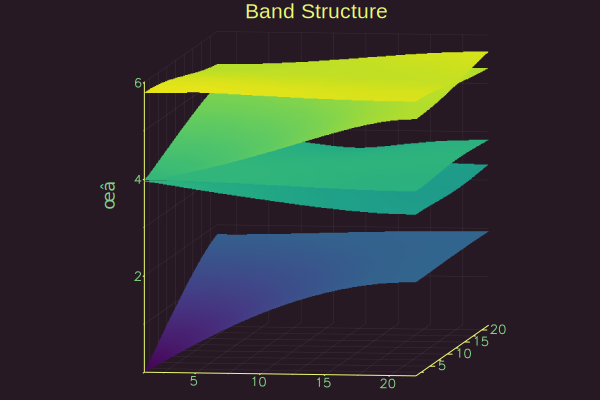

In [23]:
p = plot(sim2, bands2, gaps2; camera=(15,20));
savefig(p,"test2/pc_band_structure2.pdf")
p

The camera argument sets the viewpoint. It's not at all necessary.

Just because we can, let's also look at the band structure mapped over the boundaries of the reduced zone

In [24]:
bands2a, gaps2a = band_structure(sim2; waveguide=1, num_bloch=51, zone=:reduced);

waveguide band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:00


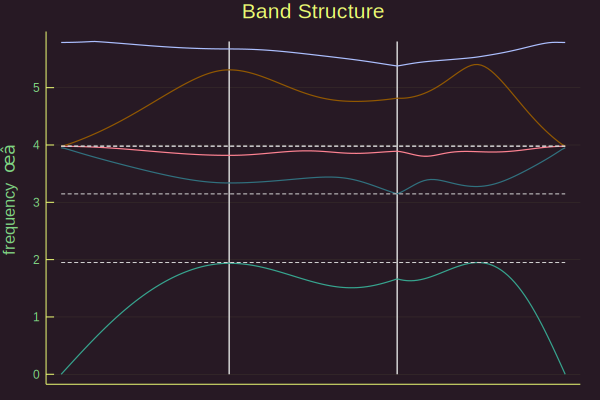

In [25]:
p = plot(sim2, bands2a, gaps2a);
savefig(p, "test2/pc_band_structure2_alt.pdf")
p

We see there is a pretty wide gap between about 2 and 3. So let's venture a guess and scatter at œâ = 2.5
note this time we are not explicitly building the dispersion curves, as this
is done during the scattering calculation. we can check after to see if our
guess was a safe one



In [26]:
œà2_sct, œà2_tot = scattering(sim2, 2.4, [1]);

Building dispersion for waveguide 1


waveguide band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:00
waveguide dispersion 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:02


Note that this time we did not call `build_dispersions!` first, because we are leaving it to happen in `scattering`

let's again plot

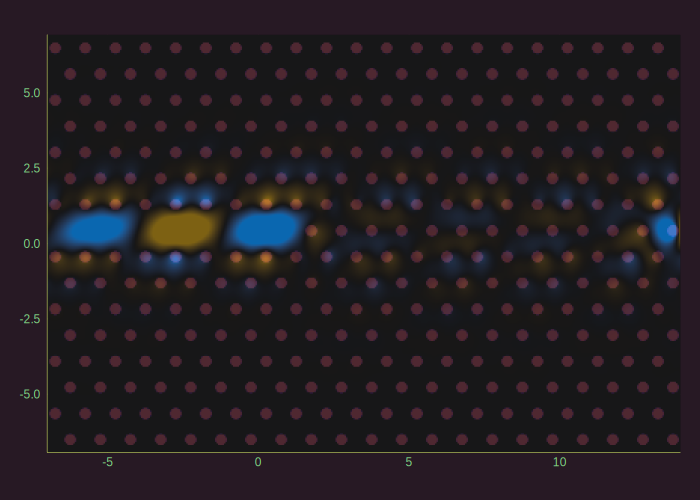

In [27]:
p = plot(sim2, œà2_tot, by=real, truncate=false, seriesalpha=.7, size=(700,500));
savefig(p, "test2/pc_scattering2.pdf")
p

Clearly some additional work is needed as the total wave is not being exponentially suppressed in the crystal.

Perhaps you don't like that color scheme? Or some other parameters?

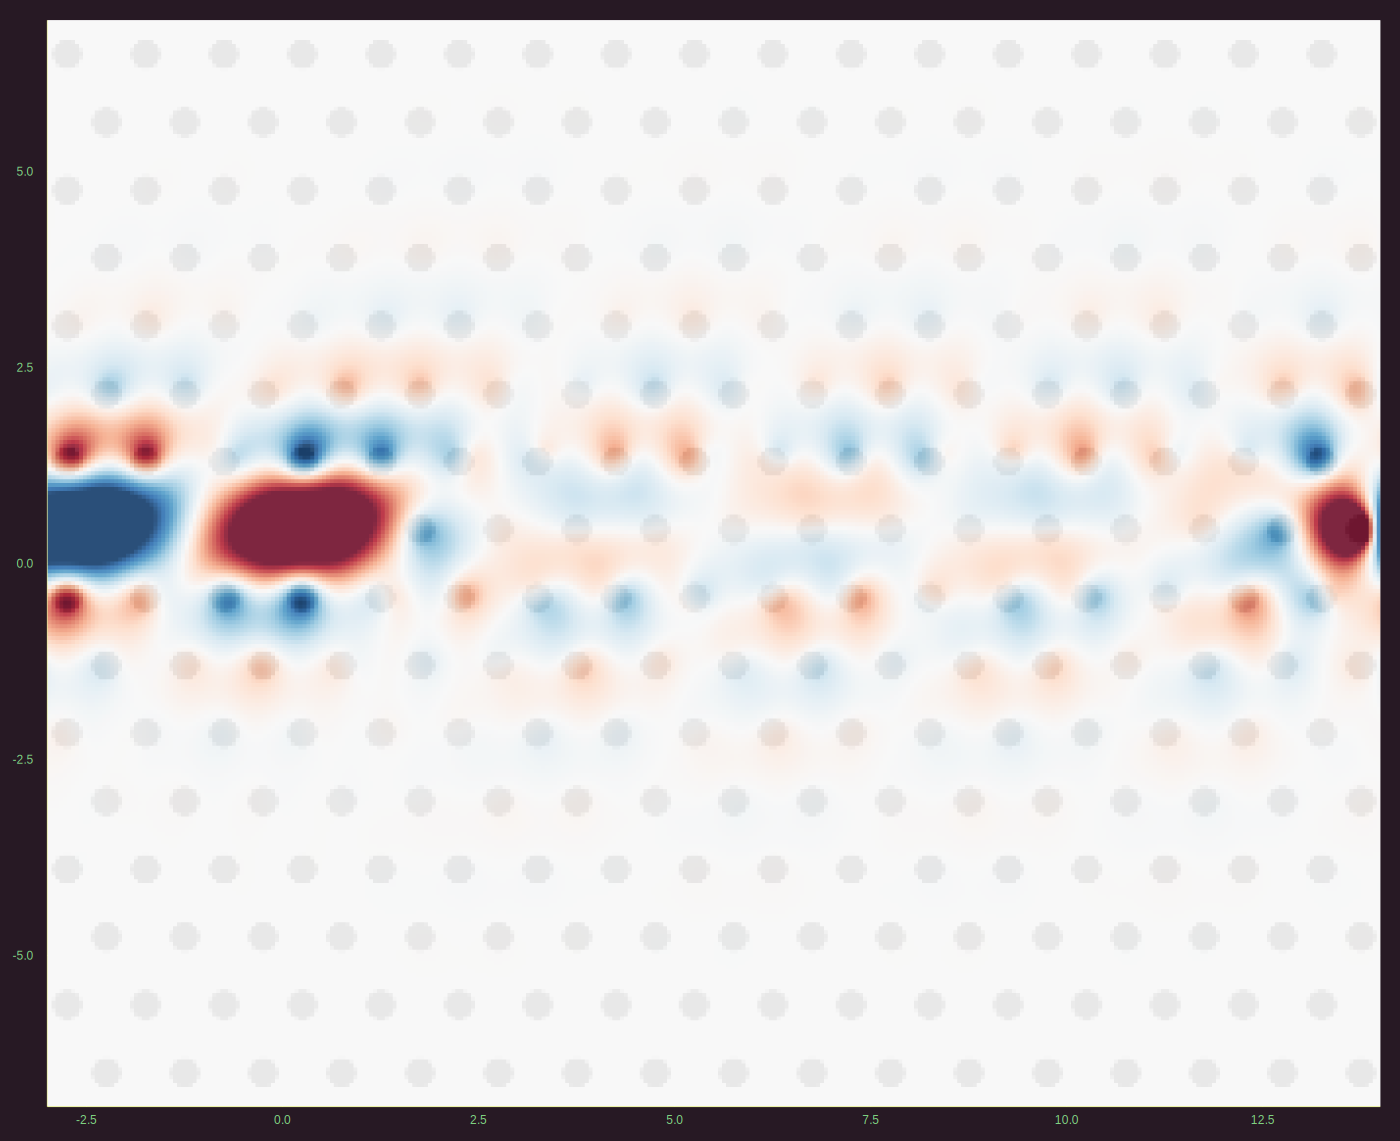

In [28]:
p = plot(sim2, œà2_tot, :default, by=real);
savefig(p, "test2/pc_scattering2_alt.pdf")
p

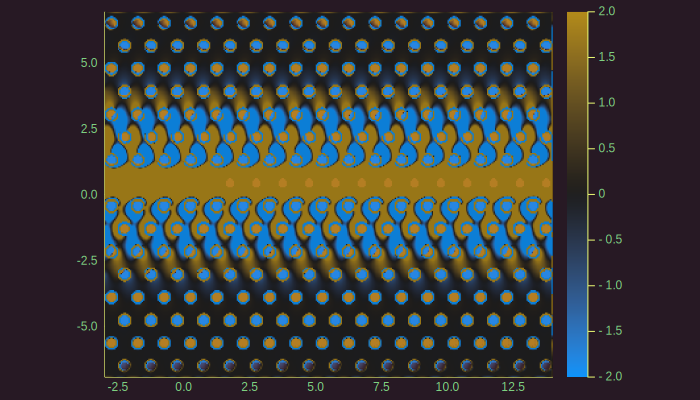

In [93]:
‚àá¬≤ = ScalarFDFD.laplacian(sim2, 2.4); Œ≤=+1.1
plot(sim2, ‚àá¬≤*((œà2_tot-œà2_sct).*exp.(-1im*Œ≤*sim2.dis.x[1] .+ 0sim2.dis.x[2])[:] + 2.4^2*sim2.sct.Œµ‚ÇÄ[1][:].*(œà2_tot-œà2_sct).*exp.(-1im*Œ≤*sim2.dis.x[1] .+ 0sim2.dis.x[2])[:]), colorbar=true, size=(700,400), by=real, clims=(-2,2))

In [87]:
wg_sim = ScalarFDFD.extract_waveguide_simulation(sim2,1)

Simulation: 

sys: 	domain 1 type: pc_waveguide
	domain 2 type: pc_waveguide_background


bnd: 		-------------------------
	bound.	|	   :p    	|
	cond-	|   :p    	   :p   |
	 ition	|	   :p    	|
		-------------------------
		|	+6.928		|
	‚àÇŒ©	| -4.000	-3.000	|
		|	-6.928		|
		-------------------------
		|	+6.928		|
	‚àÇŒ©_tr	| -4.000	-3.000	|
		|	-6.928		|
		-------------------------
	bound.	|	:none   	|
	layer	|:none   	:none   |
		|	:none   	|
		-------------------------
	bound.	|	+0.000		|
	layer	| +0.000	+0.000	|
	depth	|	+0.000		|
		-------------------------


dis: 	N: [20, 277]
	sub-pixel number: 20
	dx: [0.05, 0.0500231]

sct: 

tls: 	D‚ÇÄ: 0.0
	œâ‚ÇÄ: 10.0
	Œ≥‚üÇ: 1.0e8

lat: Bravais: 
	primitive vector 1: 1.00, ‚à†0.00¬∞
	primitive vector 2: 16.00, ‚à†60.00¬∞
	origin: (-7.00, -6.93)

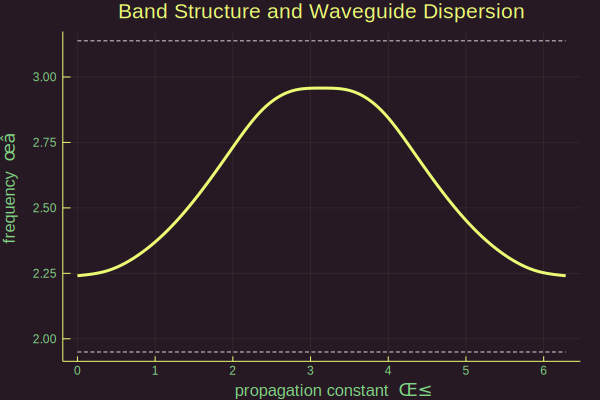

In [74]:
plot(sim2,sim2)

and let's make a movie, but with contours this time

In [35]:
animate(wave(sim2, œà2_tot; by=real), seriestype=:contour, levels=30, clims=(-2,2), "test2/pc_scattering2.gif")

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/wrs/wrs julia/ScalarFDFD/tests/test2/pc_scattering2.gif
‚îî @ Plots /Users/wrs/.julia/packages/Plots/Ufx0i/src/animation.jl:90


Plots.AnimatedGif("/Users/wrs/wrs julia/ScalarFDFD/tests/test2/pc_scattering2.gif")

# C. Corner in Square Lattice

In [10]:
‚àÇŒ© = [-4  -4
       13  13]

bc = :d
bl = [:none   :none
      :pml    :pml]

bl_depth = 5
bnd = Boundary(‚àÇŒ©=‚àÇŒ©, bc=bc, bl=bl, bl_depth=bl_depth)

dx = .04
dis = Discretization(dx)

pc = build_pc_domain(Bravais(a=1, b=1), Regions())
pc = add_circle_to_pc(pc, :center; R=.2, n‚ÇÅ = 3)

sys = System(pc)
sys = add_pc_waveguide(sys; width=1, direction=:north)
sys = add_pc_waveguide(sys; width=1, direction=:east)

sct = Scattering([Channels(1,1)])

sim3 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct, disp_opt=true)

‚îå Warning: boundary layer [1,1] set to :none, but has thickness 5 > 0
‚îÇ         setting bl_depth[1,1] = 0
‚îî @ ScalarFDFD /Users/wrs/wrs julia/ScalarFDFD/src/definitions.jl:287
‚îå Warning: boundary layer [1,2] set to :none, but has thickness 5 > 0
‚îÇ         setting bl_depth[1,2] = 0
‚îî @ ScalarFDFD /Users/wrs/wrs julia/ScalarFDFD/src/definitions.jl:287
sub-pixel smoothing 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:04
sub-pixel smoothing 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:03


Simulation: 

sys: 	domain 1 type: pc_waveguide, right, waveguide 2
	domain 2 type: pc_waveguide, top, waveguide 1
	domain 3 type: pc_waveguide_background, right, waveguide 2
	domain 4 type: pc_waveguide_background, top, waveguide 1
	domain 5 type: bulk_pc_waveguide_x
	domain 6 type: bulk_pc_waveguide_y
	domain 7 type: pc

	waveguide 1 domains: [2, 4]
	waveguide 2 domains: [1, 3]



bnd: 		-------------------------
	bound.	|	   :d    	|
	cond-	|   :d    	   :d   |
	 ition	|	   :d    	|
		-------------------------
		|	+13.000		|
	‚àÇŒ©	| -4.000	+13.000	|
		|	-4.000		|
		-------------------------
		|	+8.000		|
	‚àÇŒ©_tr	| -4.000	+8.000	|
		|	-4.000		|
		-------------------------
	bound.	|	:pml_out	|
	layer	|:none   	:pml_out|
		|	:none   	|
		-------------------------
	bound.	|	+5.000		|
	layer	| +0.000	+5.000	|
	depth	|	+0.000		|
		-------------------------


dis: 	N: [425, 425]
	sub-pixel number: 20
	dx: [0.04, 0.04]

sct: 	Channel 1:
		waveguide: 1
		quantum number: 1

tls: 	D‚ÇÄ: 0.0

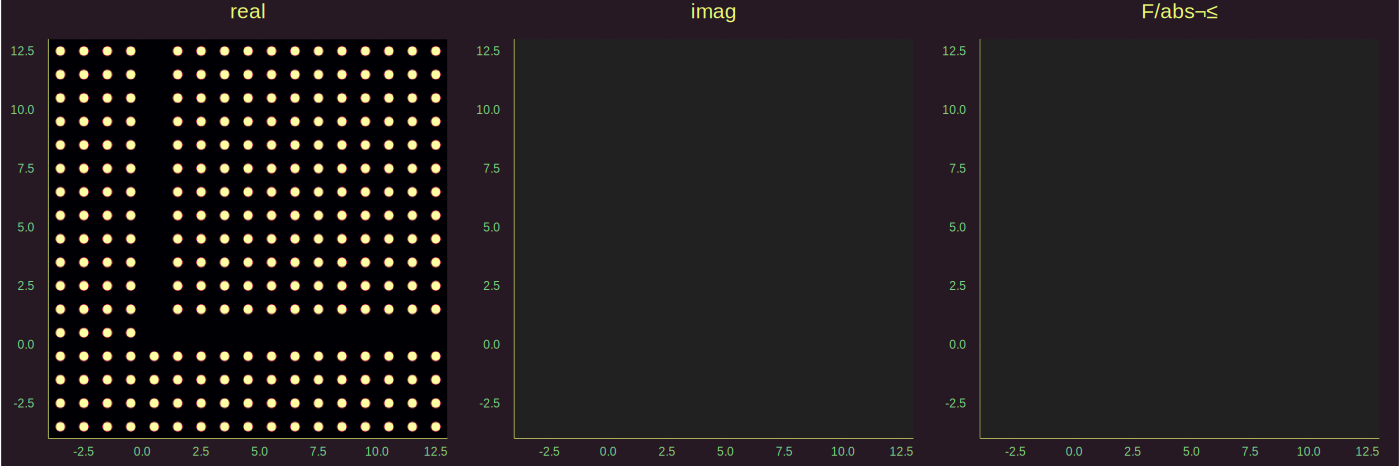

In [11]:
p = plot(sim3);
savefig("test3/pc_sim3.pdf")
p

waveguide band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:01


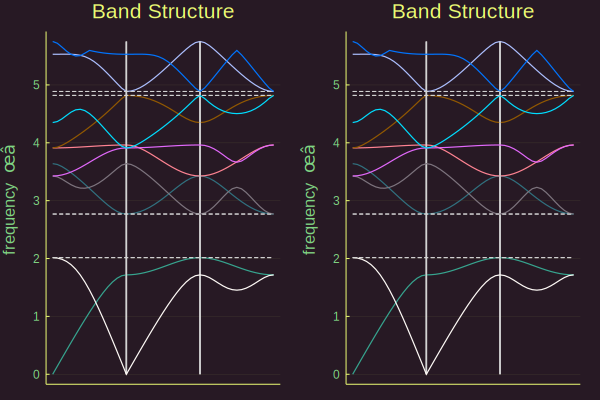

In [12]:
bands3, gaps3 = band_structure(sim3; waveguide=1)

p = plot(sim3, bands3, gaps3);
savefig("test3/pc_band_structure3.pdf")
p

This was over zones 1 & 2 by default. Can be specified with `zone` optional argument to `band structure`

### Unidirectional Eigenvalue Problem

In [13]:
k3, œà3 = eig_k(sim3, 2.6, :u, 4; direction=[1,-1])
k3

Boundary: 
		-------------------------
	bound.	|	   :d    	|
	cond-	|   :d    	   :d   |
	 ition	|	   :d    	|
		-------------------------
		|	+13.000		|
	‚àÇŒ©	| -4.000	+13.000	|
		|	-4.000		|
		-------------------------
		|	+8.000		|
	‚àÇŒ©_tr	| -4.000	+8.000	|
		|	-4.000		|
		-------------------------
	bound.	|	:pml_in 	|
	layer	|:none   	:pml_out|
		|	:none   	|
		-------------------------
	bound.	|	+5.000		|
	layer	| +0.000	+5.000	|
	depth	|	+0.000		|
		-------------------------



4-element Array{Complex{Float64},1}:
  2.621379350474774 + 0.06332621467524076im
 2.6213793504747747 - 0.0633262146752434im 
  2.444337558415891 - 0.08063442899119919im
 2.4443375584158327 + 0.08063442899119835im

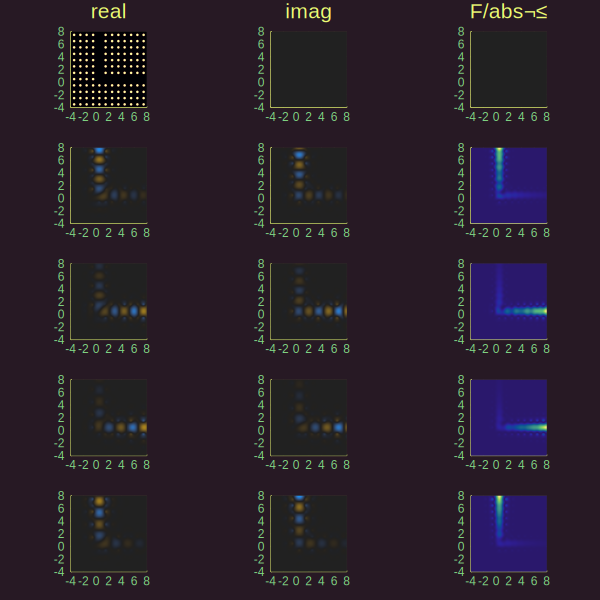

In [14]:
p = plot(sim3,œà3, size=(600,600));
savefig("test3/pc_uni_eig3.pdf");
p

In [33]:
animate(wave(sim3, œà3; by=real, truncate=true), size=(600,600), clims=(-.45,.45), seriesalpha=.7, "test3/pc_scattering3.gif")

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/wrs/wrs julia/ScalarFDFD/tests/test3/pc_scattering3.gif
‚îî @ Plots /Users/wrs/.julia/packages/Plots/Ufx0i/src/animation.jl:90


Plots.AnimatedGif("/Users/wrs/wrs julia/ScalarFDFD/tests/test3/pc_scattering3.gif")

In [30]:
œà3_sct, œà3_tot = scattering(sim3, 2.5, [1]);

Building dispersion for waveguide 1


waveguide band structure 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:01
waveguide dispersion 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:06


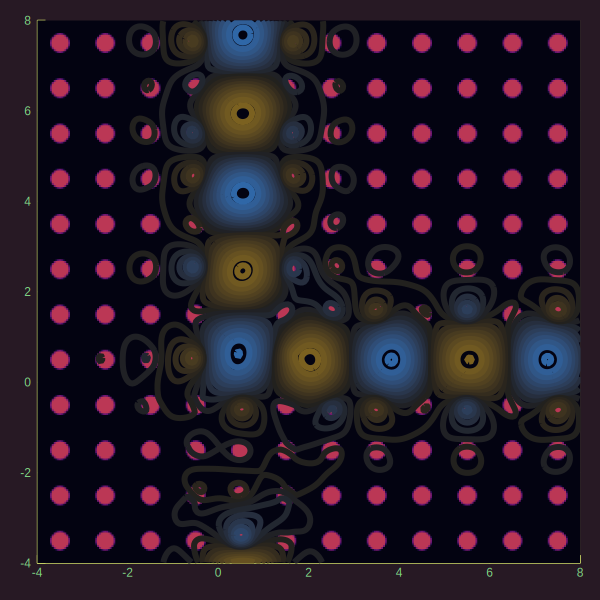

In [31]:
p = plot(sim3, œà3_tot; by=real, seriestype=:contour, size=(600,600), levels=30)
savefig(p, "test3/pc_scattering3.pdf")
p